In [ ]:
# Playgroud Series - Regression of Used Car Prices
    # https://www.kaggle.com/competitions/playground-series-s4e9
    # Your Goal: The goal of this competition is to predict the price of used cars based on various attributes.
    # Metric: Submissions are evaluated using the Root Mean Squared Error (RMSE): how close each prediction is to the actual values, on average.

    # Original Dataset + Notebooks: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset/code

# General improvements:   
    # Create new notebook for each modification, to make it easier to measure progresses.
    # Just submitt if val results increase: just 5 subs/day.

In [ ]:
# V1: Public position: 627 of 847   -->  77th of 100 
# V2: Public position: 549 of 1000  -->  55th of 100 

In [ ]:
# Strategy:
    #1 Tune Catboost - ok
    #2 Instead of dropping "clean_title", set 'unknown', to see if it improves the model, even with just 'yes' and 'unknown' options -> slightly worse, so kept removing the feature.
    #3 Feat Engeneering: Features for -150 RMSE [https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531532] -> imporved slightly on val, but not for private data.
    #4 Check duplicates: when removed, got worst train and val result, and on Kaggle as well. Don't remove!

# Imports

In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost                        import CatBoostRegressor, Pool
from sklearn.model_selection         import train_test_split, GridSearchCV

pd.set_option('max_colwidth', 200) #cols to be shown
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x) #pandas decimal places

## Load Dataset

In [173]:
train = pd.read_csv('..\\dt\\kaggle\\train.csv', index_col='id')
print(train.shape)
train.reset_index(drop=True, inplace=True)
train[:2]

(188533, 12)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999


# Data Cleaning

## Rename Cols

In [174]:
# Reanme Cols: no need.

## Meanings

In [175]:
# Meanings: all good, but:
    # Clean Title: suggests that the vehicle has never been in an accident severe enough to warrant it being classified as a total loss by an insurance company. 
        # It does not guarantee that the vehicle has never been in any accident at all
        # Also that there are no liens or disputes regarding ownership. 

In [176]:
train[:5]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Cat Variations

In [177]:
# Variations of Cat
num_feat = train.select_dtypes(include=['float64', 'int64']).columns
cat_feat = train.select_dtypes(include=['object']).columns
print(f"- Distinct values:\n{train[cat_feat].apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{train[cat_feat].apply( lambda x: x.unique() ) } " )

- Distinct values:
brand             57
model           1897
fuel_type          8
engine          1117
transmission      52
ext_col          319
int_col          156
accident           3
clean_title        2
dtype: int64 

- Variations:
brand           [MINI, Lincoln, Chevrolet, Genesis, Mercedes-Benz, Audi, Ford, BMW, Tesla, Cadillac, Land, GMC, Toyota, Hyundai, Volvo, Volkswagen, Buick, Rivian, RAM, Hummer, Alfa, INFINITI, Jeep, Porsche, McLar...
model           [Cooper S Base, LS V8, Silverado 2500 LT, G90 5.0 Ultimate, Metris Base, A6 2.0T Sport, A8 L 3.0T, Silverado 1500 1LZ, F-150 XLT, M4 Base, Camaro 1LT, Model S P100D, Escalade ESV Platinum, S4 3.0T...
fuel_type                                                                                                                              [Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel, Plug-In Hybrid, –, not supported]
engine          [172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel, 252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel, 320.0H

## Missings

In [178]:
# Missings

In [179]:
# PS: Since I'll start using a Catboost, this is the strategy to handle missings: (gpt)
# - For Numerical features: just keep the missings, it handles them:
        # CatBoost can handle missing values using different strategies. The default mode is to treat missing values as the minimum value (less than all other values) when making splits in decision trees. 
        # This allows the model to consider missing values during the training process without needing to fill them in manuall.
# - For Categorical Features: set 'unknown' or sth like that to missings:
        # While CatBoost can handle missing values in numerical features natively, for categorical features, it is recommended to create a specific category (like "missing" or an empty string) to represent missing values. 
        # This allows the model to treat these entries appropriately during training and ensures that the splits can include this category

In [180]:
train.isna().sum().sort_values()

brand               0
model               0
model_year          0
milage              0
engine              0
transmission        0
ext_col             0
int_col             0
price               0
accident         2452
fuel_type        5083
clean_title     21419
dtype: int64

In [181]:
train.clean_title.value_counts(dropna=False)

clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64

In [182]:
#Remove clean_title since there is no variation.  -> Instead of dropping "clean_title", set 'unknown', to see if it improves the model, even with just 'yes' and 'unknown' options
# Set 'unknown' on NaN 
#train.loc[train.clean_title.isna(), 'clean_title'] = 'Unknown'
    #-> V2: Set 'Unknown', and did not improve model's performance. Keep removing the feature!

train.drop(columns='clean_title', inplace=True)
#remove also from cat_feat
cat_feat = cat_feat.drop('clean_title')

In [183]:
train.accident.value_counts(dropna=False)

accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64

In [184]:
# Set 'unknown' on NaN 
train.loc[train.accident.isna(), 'accident'] = 'unknown'

In [185]:
train.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [186]:
#Inspect:
#train.loc[train.fuel_type == 'not supported']

#for now:
# Set 'unknown' on NaN 
train.loc[train.fuel_type.isna(), 'fuel_type'] = 'unknown'

In [187]:
train.isna().sum().sort_values()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

## Duplicates

In [ ]:
#  --->> duplicates: when removed, got worst train and val result, and on Kaggle as well. Don't remove!

In [188]:
# Check Duplication

# Impact of Duplicates
    # Bias in Training: Duplicates can lead to biased training, as the model may give more weight to the duplicated instances. This can skew the model's understanding of the underlying patterns in the data.
    # Overfitting: If duplicates are present, the model might overfit to those repeated instances, leading to poor generalization on unseen data.
    # Evaluation Metrics: Duplicates can affect the evaluation metrics, especially if the duplicates are present in both the training and validation sets.
#train.duplicated().sum()

6

In [189]:
#inspect duplicates:
#train.loc[train.duplicated(keep=False)].sort_values(by='model')

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
79803,RAM,1500 Big Horn,2021,43329,Gasoline,5.7L V8 16V MPFI OHV,Automatic,Bright White Clearcoat,Black,None reported,43642
186635,RAM,1500 Big Horn,2021,43329,Gasoline,5.7L V8 16V MPFI OHV,Automatic,Bright White Clearcoat,Black,None reported,43642
15968,Buick,Envision Essence,2020,35569,Gasoline,2.5L I4 16V GDI DOHC,6-Speed Automatic,Ebony Twilight Metallic,Ebony,None reported,31853
21072,Buick,Envision Essence,2020,35569,Gasoline,2.5L I4 16V GDI DOHC,6-Speed Automatic,Ebony Twilight Metallic,Ebony,None reported,31853
116398,Buick,Envision Essence,2020,121212,Gasoline,2.5L I4 16V GDI DOHC,6-Speed Automatic,Summit White,Ebony,None reported,18387
145093,Buick,Envision Essence,2020,121212,Gasoline,2.5L I4 16V GDI DOHC,6-Speed Automatic,Summit White,Ebony,None reported,18387
32090,Chevrolet,Silverado 1500 LTZ,2019,58816,Gasoline,5.3L V8 16V GDI OHV,Automatic,Silver Ice Metallic,Jet Black,None reported,43860
40633,Chevrolet,Silverado 1500 LTZ,2019,58816,Gasoline,5.3L V8 16V GDI OHV,Automatic,Silver Ice Metallic,Jet Black,None reported,43860
56537,Chevrolet,Silverado 1500 ZR2,2022,11597,Gasoline,6.2L V8 16V GDI OHV,Automatic,Glacier Blue Metallic,Jet Black,None reported,68590
178567,Chevrolet,Silverado 1500 ZR2,2022,11597,Gasoline,6.2L V8 16V GDI OHV,Automatic,Glacier Blue Metallic,Jet Black,None reported,68590


In [190]:
#train.shape

(188533, 11)

In [191]:
#drop duplicates and reset index
#train = train.drop_duplicates().reset_index(drop=True)

In [192]:
#train.shape #6 duplicated rows were removed 

(188527, 11)

## Dtypes

In [193]:
#Dtypes
train.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
price            int64
dtype: object

In [194]:
#convert to int32, lighter:
#train.model_year = train.model_year.astype(int)
train.milage = train.milage.astype(int)
train.price = train.price.astype(int)

In [195]:
#Dtypes
train.dtypes #ok

brand           object
model           object
model_year       int64
milage           int32
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
price            int32
dtype: object

In [196]:
train[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


In [197]:
#Many strings, 3 integers only, ok

In [198]:
#At least 3 features have this, replace:
train = train.replace('–', 'dash') # -> this had no impact on score!

# Checkpoint 1

In [199]:
train.to_parquet('..\\dt\\v2\\train_clean.parquet')

In [200]:
train = pd.read_parquet( '..\\dt\\v2\\train_clean.parquet')
print(train.shape)
train[:2]

(188527, 11)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


# Descriptive Statistical

In [32]:
# num features

In [33]:
num_feat

Index(['model_year', 'milage', 'price'], dtype='object')

In [34]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( train[num_feat].apply( np.mean ) ).T
ct2 = pd.DataFrame( train[num_feat].apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( train[num_feat].apply ( np.std ) ).T
d2 = pd.DataFrame ( train[num_feat].apply ( min ) ).T
d3 = pd.DataFrame ( train[num_feat].apply ( max ) ).T
d4 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.kurtosis() ) ).T

#Concatenate
nm = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
nm.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [35]:
nm

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,model_year,1974.0,2024.0,50.0,2015.8,2017.0,5.7,-1.0,0.7
1,milage,100.0,405000.0,404900.0,65705.6,57785.0,49798.4,0.9,0.7
2,price,2000.0,2954083.0,2952083.0,43878.2,30825.0,78820.5,20.3,623.9


In [36]:
# Distributions - num features

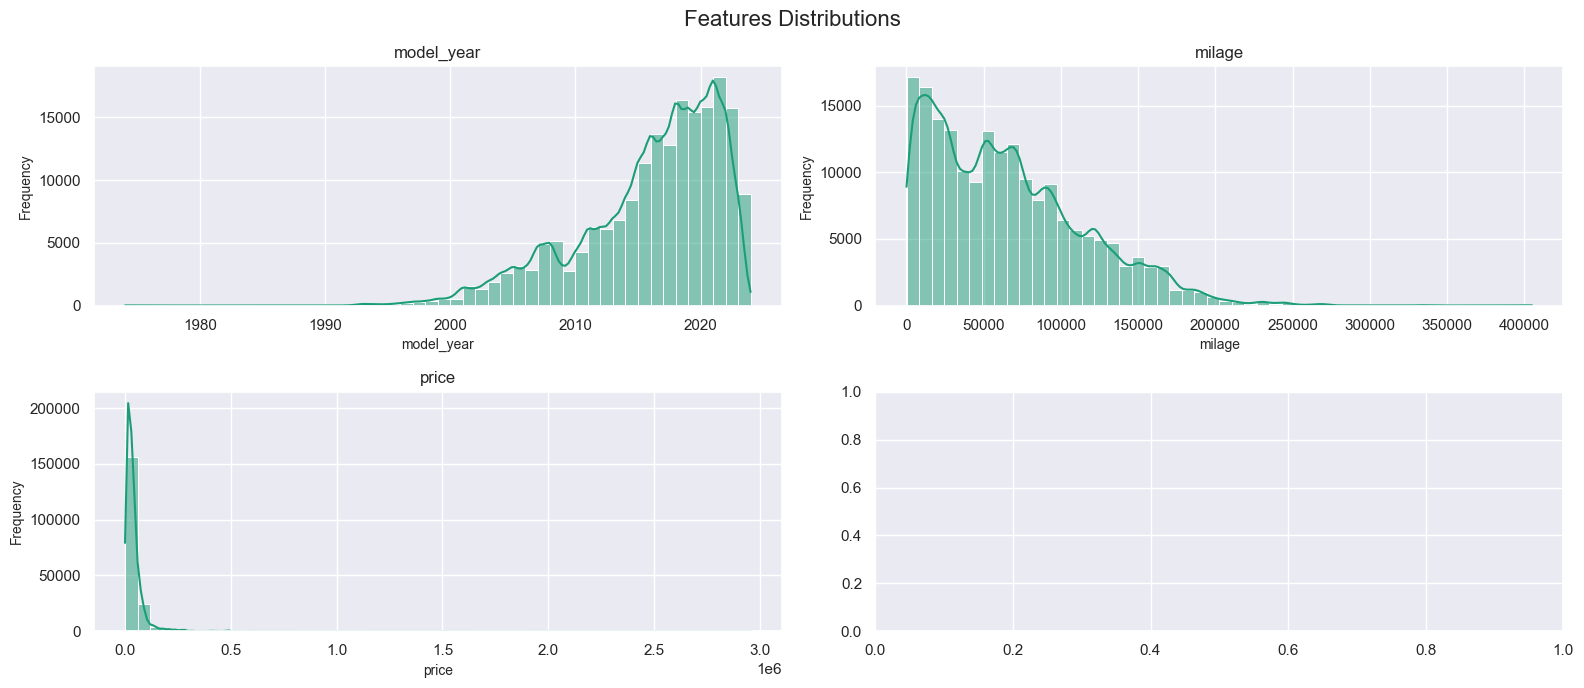

In [37]:
# Histogram
# Set the style for seaborn
sns.set(style="darkgrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 7)) 
fig.suptitle("Features Distributions", fontsize=16)

# Loop through the columns and create histograms
for ax, col in zip(axs.flatten(), train[num_feat]):
    sns.histplot(train[col], ax=ax, bins=50, kde=True, color=sns.color_palette("Dark2")[0])  # Add KDE for smoothness
    ax.set_title(col, fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True)  # Add grid lines for better readability

# Adjust layout
fig.tight_layout()  
fig.subplots_adjust(top=0.9)

In [38]:
# Distributions - cat features

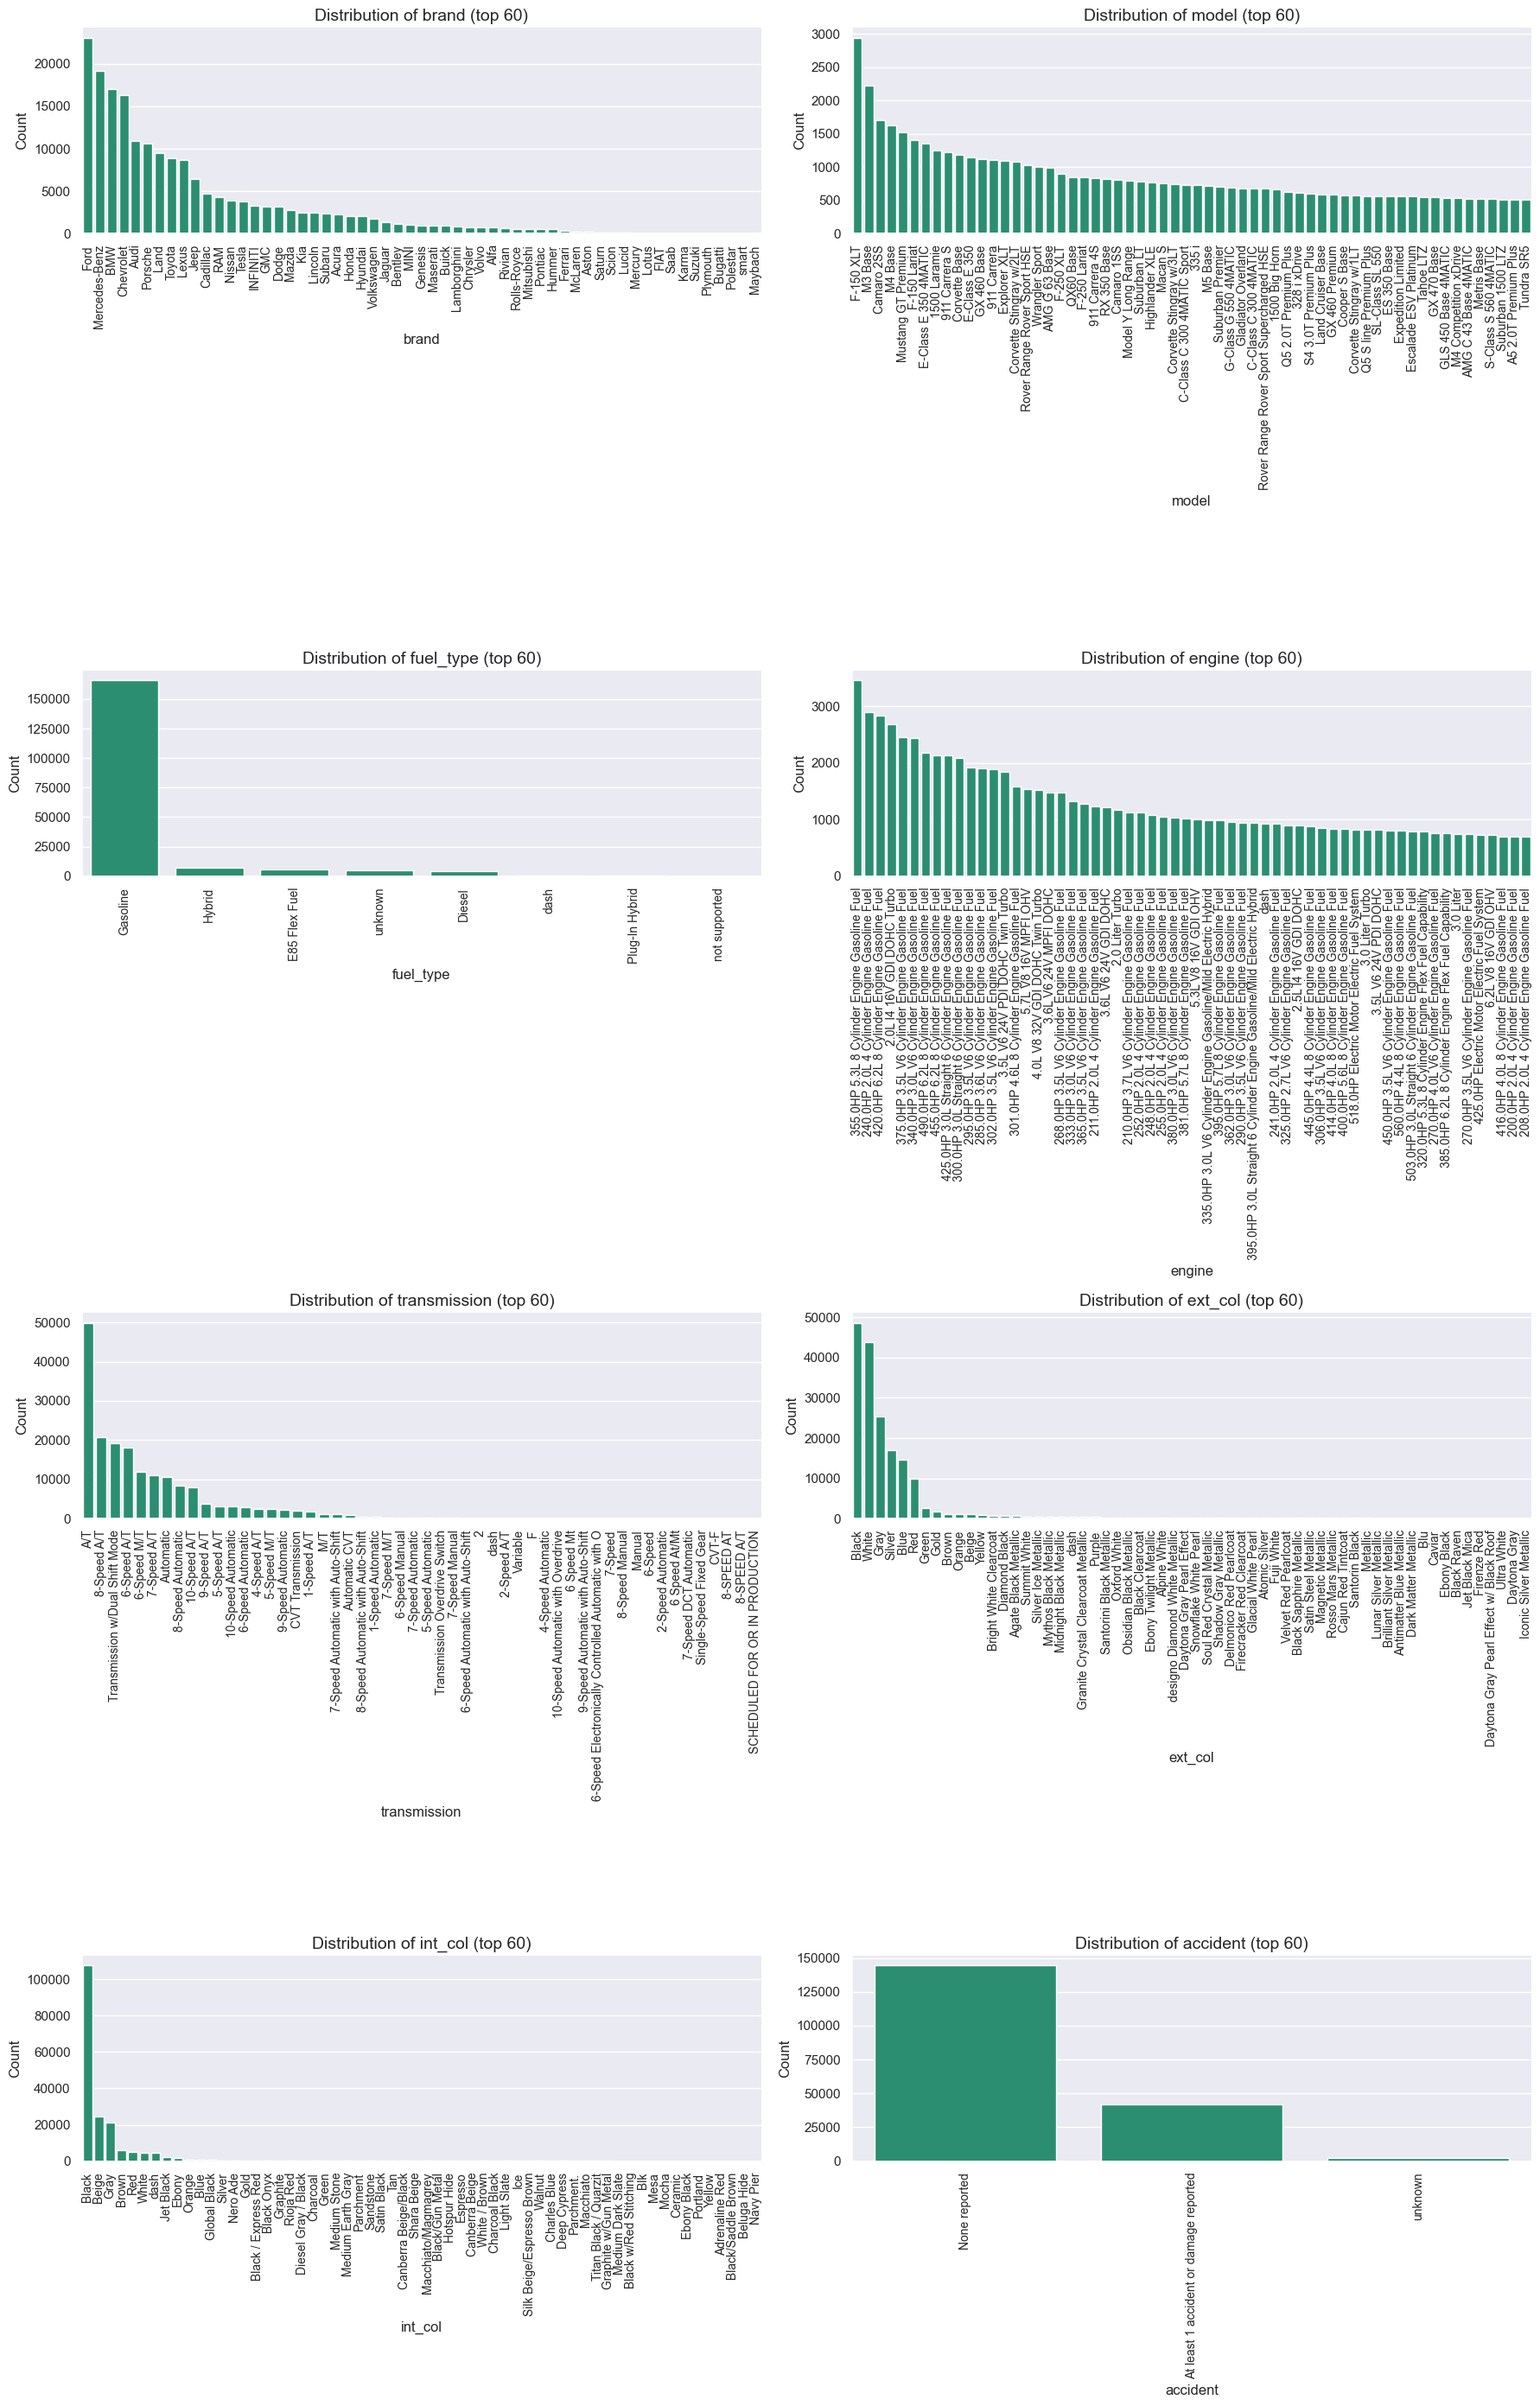

In [39]:
# Histogram
# Set the style for seaborn
sns.set(style="darkgrid")

num_cols = 2
num_rows = (len(cat_feat) + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(18, num_rows * 7))  # Adjust height based on number of rows

# Loop through each categorical column and create a bar plot
for i, col in enumerate(cat_feat):
    plt.subplot(num_rows, num_cols, i + 1)  # Create a subplot for each column
    
    # Count occurrences and sort in descending order, limit to 60
    count_data = train[col].value_counts().nlargest(60).reset_index()
    count_data.columns = [col, 'Count']  # Rename columns for clarity

    # Create a count plot with specified color
    sns.barplot(data=count_data, x=col, y='Count', color=sns.color_palette("Dark2")[0], order=count_data[col])
    
    plt.title(f'Distribution of {col} (top 60)', fontsize=14)  # Set the title with larger font size
    plt.xlabel(col, fontsize=12)  # Set x-axis label
    plt.ylabel('Count', fontsize=12)  # Set y-axis label
    plt.xticks(rotation=90, fontsize=10)  # Rotate x labels for better readability
    sns.despine()  # Remove the top and right spines for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

# Feature Engeneering

In [201]:
train[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


In [202]:
# CatBoost handles well with cathegorical features. Encoding 2 features improves it's performance?

# fuel_type_dict = {
#     'Gasoline': 0,
#     'Hybrid': 1,
#     'E85 Flex Fuel': 2,
#     'unknown': 3,
#     'Diesel': 4,
#     'dash': 5,
#     'Plug-In Hybrid': 6,
#     'not supported': 7
# }
# accident_dict = {
#     'None reported': 0,
#     'At least 1 accident or damage reported': 1,
#     'unknown': 2
# }
# train['fuel_type'] = train['fuel_type'].map(fuel_type_dict)
# train['accident'] = train['accident'].map(accident_dict)
# train.fuel_type = train.fuel_type.astype(int)
# train.accident = train.accident.astype(int)

#V2: -> Using CatBoost, this slightly improved train performance, but decreased val, so will keep the string cathegories while using CatBoost

In [204]:
#Create new features:
expensive_ext_color = ['Blue Caelum', 'Dark Sapphire', 'Bianco Monocerus', 'C / C', 'Ice', 'Tempest', 'Beluga Black', 'Bianco Icarus Metallic', 
       'BLU ELEOS', 'Shadow Black', 'Nero Noctis', 'Sandstone Metallic', 'Lizard Green', 'Balloon White', 'Onyx', 'Donington Grey Metallic',
       'China Blue', 'Diamond White', 'Rosso Corsa', 'Granite', 'Rosso Mars Metallic', 'Carpathian Grey', 'Kemora Gray Metallic',
       'Grigio Nimbus', 'dash', 'Bianco Isis', 'Python Green', 'Fountain Blue', 'Custom Color', 'Vega Blue', 'Designo Magno Matte',
       'Brands Hatch Gray Metallic', 'Rift Metallic', 'Gentian Blue Metallic', 'Arancio Borealis', 'BLUE', 'Aventurine Green Metallic', 'Apex Blue',
       'Daytona Gray Pearl Effect', 'Daytona Gray Pearl Effect w/ Black Roof', 'Matte White', 'Carpathian Grey Premium Metallic', 'Blue Metallic',
       'Santorini Black Metallic', 'Quartzite Grey Metallic', 'Carrara White Metallic', 'BLACK', 'Kinetic Blue', 'Nero Daytona']

#How top x most lists were extracted:
    # N_SAMPLES = 20
    # some_list = train.groupby(by='ext_col')['price'].mean().sort_values(ascending=False)
    # some_list = some_list.head(N_SAMPLES).index.tolist()

expensive_int_color = ['Dark Auburn', 'Hotspur', 'Cobalt Blue', 'Beluga Hide', 'Linen',
                       'Beluga', 'Black / Brown', 'Nero Ade', 'Sahara Tan', 'Portland']

expensive_hp = [443.0, 473.0, 493.0, 502.0, 521.0, 542.0, 543.0, 571.0, 572.0, 573.0, 580.0,
                591.0, 602.0, 611.0, 616.0, 620.0, 624.0, 640.0, 641.0, 651.0, 710.0, 715.0, 760.0, 788.0, 797.0]

train['expensive_color_ext_encoded'] = train.ext_col.isin(expensive_ext_color).astype(int)
train['expensive_color_int_encoded'] = train.int_col.isin(expensive_int_color).astype(int)
train['expensive_hp'] = train['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float).isin(expensive_hp).astype(int)
train['cylinder'] = train['engine'].str.extract(r'(\d+\.?\d*) Cylinder').astype(float) #NaN if float, Catboost can handle NaN for numeric.
train['got_v'] = train['model'].str.extract(r'\b(V\d+)\b').notna().astype(int) #V8, V10..

In [205]:
#inspect:
train.cylinder.value_counts(dropna=False)

cylinder
6.0     66301
8.0     52588
NaN     37849
4.0     29051
12.0     1266
10.0      698
5.0       627
3.0       147
Name: count, dtype: int64

In [206]:
train.sample(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,expensive_color_ext_encoded,expensive_color_int_encoded,expensive_hp,cylinder,got_v
159446,Mercedes-Benz,AMG GT AMG GT S,2020,2000,Gasoline,577.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,112500,0,0,0,8.0,0
143804,Ford,Mustang SVT Cobra,1992,138000,dash,dash,4-Speed A/T,White,Gray,None reported,4500,0,0,0,NaN,0
114443,Land,Rover Range Rover Sport HSE Dynamic,2017,65000,Gasoline,380.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,20900,0,0,0,6.0,0
118883,Subaru,Impreza WRX,2005,149000,Gasoline,224.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,Blue,Black,None reported,8999,0,0,0,4.0,0
78740,INFINITI,G37 x,2013,60251,Gasoline,328.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,7-Speed A/T,Red,Black,None reported,19950,0,0,0,6.0,0


In [207]:
# Setting -1 is not a good idea
train.loc[train.cylinder.isna()]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,expensive_color_ext_encoded,expensive_color_int_encoded,expensive_hp,cylinder,got_v
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,62890,0,0,0,NaN,0
11,Tesla,Model S P100D,2015,81500,unknown,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,19000,0,0,0,NaN,0
20,Land,Rover Defender S,2023,7978,Gasoline,5.2L V10 40V PDI DOHC,8-Speed Automatic,Santorini Black Metallic,Black,None reported,41998,1,0,0,NaN,0
32,Tesla,Model S P100D,2018,30300,unknown,518.0HP Electric Motor Electric Fuel System,A/T,White,White,None reported,64000,0,0,0,NaN,0
39,Buick,Enclave Premium,2022,9642,Gasoline,3.6L V6 24V GDI DOHC,9-Speed Automatic,Ebony Twilight Metallic,Dark Galvanized,None reported,63900,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188505,Land,Rover Range Rover Velar P380 SE R-Dynamic,2022,15198,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Firenze Red,Ebony,None reported,23739,0,0,0,NaN,0
188507,Lexus,GS 350 F Sport,2022,82046,Gasoline,3.5L V6 24V PDI DOHC,8-Speed Automatic,Caviar,Black,None reported,48990,0,0,0,NaN,0
188509,GMC,Sierra 1500 Denali Ultimate,2023,9978,Gasoline,6.2L V8 16V GDI OHV,10-Speed A/T,White Frost Tri-Coat,Walnut,At least 1 accident or damage reported,48999,0,0,0,NaN,0
188514,Mercedes-Benz,GLC 300 GLC 300,2022,18031,Gasoline,2.0 Liter Turbo,Automatic,White,Black,None reported,39998,0,0,0,NaN,0


In [208]:
#Improvement: if there cylinder is null, and got_v ==1, extract the same it was extracter, to get from got_v!

In [209]:
train.got_v.value_counts()

got_v
0    186325
1      2202
Name: count, dtype: int64

In [210]:
train.loc[train.got_v==1].sample(1)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,expensive_color_ext_encoded,expensive_color_int_encoded,expensive_hp,cylinder,got_v
40416,Audi,R8 5.2 V10,2019,8940,Gasoline,5.2L V10 40V GDI DOHC,7-Speed Automatic with Auto-Shift,Tango Red Metallic,Black,unknown,62900,0,0,0,NaN,1


In [211]:
train.isna().sum() #ok

brand                              0
model                              0
model_year                         0
milage                             0
fuel_type                          0
engine                             0
transmission                       0
ext_col                            0
int_col                            0
accident                           0
price                              0
expensive_color_ext_encoded        0
expensive_color_int_encoded        0
expensive_hp                       0
cylinder                       37849
got_v                              0
dtype: int64

In [212]:
train.dtypes #ok

brand                           object
model                           object
model_year                       int64
milage                           int32
fuel_type                       object
engine                          object
transmission                    object
ext_col                         object
int_col                         object
accident                        object
price                            int32
expensive_color_ext_encoded      int32
expensive_color_int_encoded      int32
expensive_hp                     int32
cylinder                       float64
got_v                            int32
dtype: object

# EDA

In [213]:
#pass for now

# Dataset Split

In [214]:
train[:1]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,expensive_color_ext_encoded,expensive_color_int_encoded,expensive_hp,cylinder,got_v
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200,0,0,0,4.0,0


In [215]:
X = train.drop(columns="price") 
y = train.price

#split between train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, test_size = 0.20) #stratify by y

In [216]:

# train data
print('X_train -> ',X_train.shape)
print('y_train -> ',y_train.shape)
# test data
print('X_test -> ',X_test.shape)
print('y_test -> ',y_test.shape)

X_train ->  (150821, 15)
y_train ->  (150821,)
X_test ->  (37706, 15)
y_test ->  (37706,)


# ML

In [217]:
# GridSearch + Cross Validation
#param_grid_cb = {'max_depth': [9 ,15, 17], 'learning_rate': [0.03, 0.05, 0.07]}#  'class_weight': [None, 'balanced', {0: 1, 1: 2.5}  , 'max_leaf_nodes': [10, 40, 100]  , 'min_samples_leaf':[5, 20, 45], }
    #'class_weight': {0: 1, 1: 2.5} balancing manually, to give more importance to the minority class.
# -> max_leaf_nodes and min_samples_leaf did not improve the model's performance

# param_grid_cb = {
#     'max_depth': [7, 9],                # Depth of trees
#     'learning_rate': [0.01, 0.03],         # Learning rate
#     'l2_leaf_reg': [1, 3],                # L2 leaf regularization
#     'n_estimators': [100],            # Number of trees
#     'bagging_temperature': [0]     # Bagging temperature
# }
# print("Parameter grid:{}".format(param_grid_cb))

#Fix the best params so far (V2), to test other improvements on model, using same parameters:
params_v2 = {'bagging_temperature': [0], 'l2_leaf_reg': [3], 'learning_rate': [0.03], 'max_depth': [9], 'n_estimators': [100]}
print("Parames V2:{}".format(params_v2))

Parames V2:{'bagging_temperature': [0], 'l2_leaf_reg': [3], 'learning_rate': [0.03], 'max_depth': [9], 'n_estimators': [100]}


In [218]:
#cat_feat #get cat features
cat_features = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident'] #removed clean_title, cause was removed on data cleaning (tried using it, did not improve model)

#Catboost Regressor with Grid Search
cb_model = GridSearchCV(CatBoostRegressor(random_state=98, cat_features=cat_features), params_v2, cv=2, n_jobs=1, scoring='neg_root_mean_squared_error', return_train_score=True)
cb_model.fit(X_train, y_train)

0:	learn: 80206.9274855	total: 90.9ms	remaining: 9s
1:	learn: 79925.1742620	total: 180ms	remaining: 8.83s
2:	learn: 79661.1297274	total: 268ms	remaining: 8.66s
3:	learn: 79396.9477985	total: 342ms	remaining: 8.21s
4:	learn: 79154.6500170	total: 430ms	remaining: 8.17s
5:	learn: 78927.5052576	total: 558ms	remaining: 8.74s
6:	learn: 78716.0237924	total: 684ms	remaining: 9.09s
7:	learn: 78498.3590057	total: 809ms	remaining: 9.3s
8:	learn: 78294.8779199	total: 934ms	remaining: 9.44s
9:	learn: 78091.8625445	total: 1.04s	remaining: 9.32s
10:	learn: 77905.9919328	total: 1.12s	remaining: 9.05s
11:	learn: 77724.2784774	total: 1.24s	remaining: 9.07s
12:	learn: 77567.5472410	total: 1.36s	remaining: 9.14s
13:	learn: 77416.0226712	total: 1.48s	remaining: 9.1s
14:	learn: 77255.2288630	total: 1.6s	remaining: 9.05s
15:	learn: 77108.2120084	total: 1.7s	remaining: 8.94s
16:	learn: 76963.3331058	total: 1.8s	remaining: 8.79s
17:	learn: 76843.9965630	total: 1.89s	remaining: 8.61s
18:	learn: 76715.4559894	to

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002588C149400>,
             n_jobs=1,
             param_grid={'bagging_temperature': [0], 'l2_leaf_reg': [3],
                         'learning_rate': [0.03], 'max_depth': [9],
                         'n_estimators': [100]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [219]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):
print("CatBoost Best parameters (val): {}".format(cb_model.best_params_))
print("CatBoost Best cross-validation score (val): {:.3f}".format(cb_model.best_score_))

CatBoost Best parameters (val): {'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
CatBoost Best cross-validation score (val): -71142.631


In [ ]:
#V2 Best: removing duplicates: (worst than not removing):
# CatBoost Best parameters (val): {'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
# CatBoost Best cross-validation score (val): -71142.631

In [ ]:
#V2 Best: with -1 in cilynder, and with NAN, same result, kept then NAN + removed duplicates:
#CatBoost Best parameters (val): {'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
#CatBoost Best cross-validation score (val): -71142.631

In [161]:
#V2 Best: sem remover duplicados
# CatBoost Best parameters (val): {'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}
# CatBoost Best cross-validation score (val): -70928.080

In [162]:
#V1 Best: 
# CatBoost Best parameters (val): {'learning_rate': 0.07, 'max_depth': 9}
# CatBoost Best cross-validation score (val): -71654.912

In [221]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL): removing duplicates (worst than not removing):
pd.DataFrame(cb_model.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
0,1,"{'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}",-70108.6,-71142.6


In [163]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL):
#pd.DataFrame(cb_model.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
0,1,"{'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}",-69282.3,-70928.1


In [118]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL): 
#pd.DataFrame(cb_model.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
0,1,"{'bagging_temperature': 0, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100}",-70108.6,-71142.6


In [222]:
# Access the best estimator
best_model = cb_model.best_estimator_

In [223]:
#Get feature importances:
# Create a Pool object with your training data and specify categorical features
train_pool = Pool(X_train, cat_features=cat_features)

# Get feature importances
feature_importances = best_model.get_feature_importance(data=train_pool)

#Feature importances:
sorted_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
top_features = [feature for feature, importance in sorted_importances]
print("Top features ordered by importance:", top_features)

Top features ordered by importance: ['milage', 'model_year', 'brand', 'engine', 'expensive_color_ext_encoded', 'transmission', 'cylinder', 'expensive_hp', 'fuel_type', 'accident', 'expensive_color_int_encoded', 'int_col', 'ext_col', 'got_v', 'model']


# Kaggle Test Prediction

In [242]:
X_prod = pd.read_csv('..\\dt\\kaggle\\test.csv')
#get id to final df:
X_prod_id = X_prod['id'].copy()
X_prod[:3]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN


In [243]:
#Clean data:

#Remove cols
X_prod.drop(columns='clean_title', inplace=True)
# Missings
X_prod.loc[X_prod.accident.isna(), 'accident'] = 'Unknown'
X_prod.loc[X_prod.fuel_type.isna(), 'fuel_type'] = 'Unknown'
#remove id to predict:
X_prod.drop(columns='id', inplace=True)
#replace the "-"
X_prod = X_prod.replace('–', 'dash')
X_prod[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported


In [248]:
#Check duplicates: (can't remove, cause I need to predict prices for all test rows!)
X_prod.duplicated().sum() #duplicates: when removed from train, got worst train and val result, and on Kaggle as well. So, did not remove.

87

In [249]:
#feature engeneering:
X_prod['expensive_color_ext_encoded'] = X_prod.ext_col.isin(expensive_ext_color).astype(int)
X_prod['expensive_color_int_encoded'] = X_prod.int_col.isin(expensive_int_color).astype(int)
X_prod['expensive_hp'] = X_prod['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float).isin(expensive_hp).astype(int)
X_prod['cylinder'] = X_prod['engine'].str.extract(r'(\d+\.?\d*) Cylinder').astype(float) #keep NaN
X_prod['got_v'] = X_prod['model'].str.extract(r'\b(V\d+)\b').notna().astype(int) #V8, V10..
X_prod[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,expensive_color_ext_encoded,expensive_color_int_encoded,expensive_hp,cylinder,got_v
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,0,0,0,4.0,0
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported,0,0,0,6.0,0


In [250]:
#predict on prod data:
y_hat_prod = best_model.predict(X_prod)

In [170]:
#Prices predicted
print(y_hat_prod.shape)
y_hat_prod[:5]

(125690,)


array([20630.51053354, 81516.89099691, 58693.24209493, 33770.51891064,
       32059.44343575])

In [440]:
# Prepare for submission: id + predictions:
# Create final dataset
df_sub = pd.concat([ pd.Series(X_prod_id, name='id') , pd.Series(y_hat_prod, name='price') ], axis=1)
df_sub[:3]

,id,price
0,188533,20630.5
1,188534,81516.9
2,188535,58693.2


In [254]:
#Check if sub contains null values -> if there are, solve, cause Kaggle won't accept!
df_sub.isnull().sum()

id       0
price    0
dtype: int64

In [255]:
# Export to submit to Kaggle
df_sub.to_csv('..\\dt\\v2\\sub_v2_dupl_removed.csv', index=False)

In [581]:
print(f"Public position: {549} of {1000}  -->  {round(549/1000*100)}th of 100 ")

Public position: 549 of 1000  -->  55th of 100 
